# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы; Контролировать добросовестность кассиров при продаже алкоголя.  В вашем распоряжении набор фотографий людей с указанием возраста.


## Цель проекта

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Метрика качества MAE.

## План работы

1. Загрузка данных.
2. Исследовательский анализ.
3. Обучение нейронной сети.
4. Оценка качества модели.

## Описание данных

- **file_name** - фотография;
- **real_age** - взраст.

## Настройка окружения

In [1]:
# настройка окружения
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Загрузка данных

In [2]:
# загрузим данные
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


## Исследование данных

In [3]:
# посмотрим размерность датафрейма
labels.shape

(7591, 2)

In [4]:
# посмотри структуру данных
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


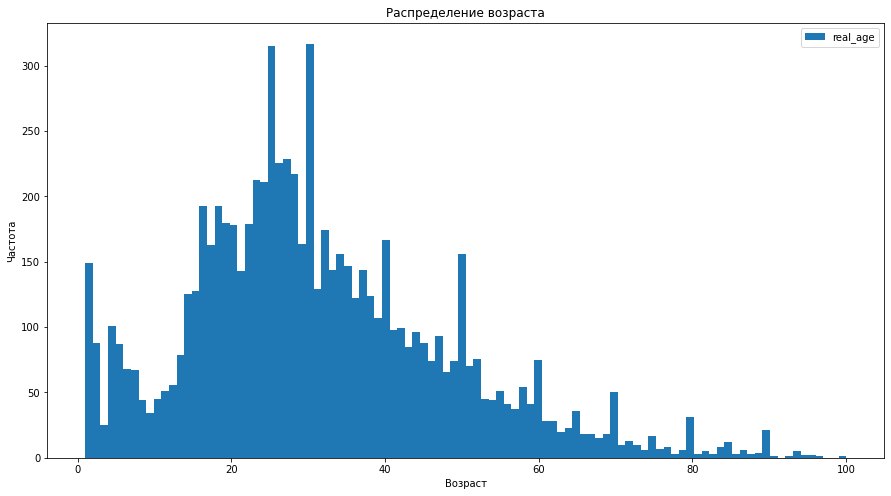

In [5]:
# посмотрим распределение данных по возрастам
labels.plot(kind='hist', figsize=(15,8), bins=100)
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

Пики в районе "юбилейных" лет, они тут могут быть связаны с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и он попросту округлял его.

In [6]:
# посмотрим статистику по данным
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


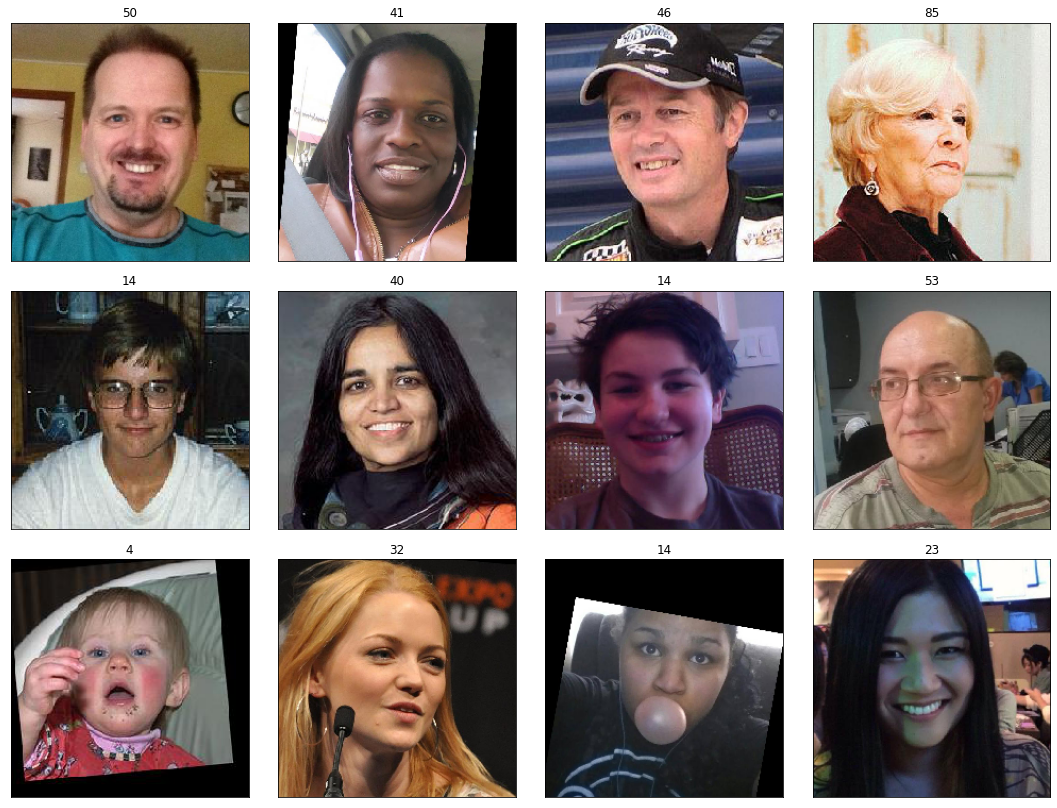

In [7]:
# выведем несколько фото
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(15,15))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()

Таким образом можно сказать следующее:
- данные загрузились успешно;
- в датасете содержится 7951 фотография;
- фотографии имеют возрастную разметку;
- возрастной интервал от 1 года до 100 лет;
- распределение данных по возрасту близко к нормальному, с небольшим смещением влево;
- половина фотгографий имеет возрастную разметку в интервале 20-41 лет;
- по всей видимости фотографии ранее прощли предварительную обработку - лица на фото расположены почти вертикально;
- часть фото имею артефакты: черный фон после выравнивания, растянутые пиксели;
- возрастная разметка приблизительно соотвествует возрасту на фото;
- на некоторых фото присутствуют объекты закрывающие лицо: очки, головные уборы, жвачка, рука, что может затруднить определение возраста.

## Обучение нейронной сети

```python
# настройка окружения
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# функция загрузки для трейна
def load_train(path):
    df = pd.read_csv(f'{path}/labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, horizontal_flip=True)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',  
        subset='training',
        seed=12345
    )
    return train_datagen_flow

# функция загрузки таргета
def load_test(path):
    df = pd.read_csv(f'{path}/labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345,  
        shuffle=False
    )
    return test_datagen_flow

# функция создания модели
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet', 
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0001)
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    
    return model

# функция моделирования
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True)
    
    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 54s - loss: 221.5414 - mae: 10.9950 - val_loss: 442.2627 - val_mae: 15.9625
Epoch 2/10
356/356 - 41s - loss: 88.0497 - mae: 7.1735 - val_loss: 188.8884 - val_mae: 10.3051
Epoch 3/10
356/356 - 43s - loss: 62.9221 - mae: 6.0731 - val_loss: 87.4485 - val_mae: 7.1333
Epoch 4/10
356/356 - 47s - loss: 43.9795 - mae: 5.0876 - val_loss: 92.7198 - val_mae: 7.1434
Epoch 5/10
356/356 - 48s - loss: 32.0522 - mae: 4.3344 - val_loss: 79.2365 - val_mae: 6.7314
Epoch 6/10
356/356 - 48s - loss: 24.3878 - mae: 3.7826 - val_loss: 81.1053 - val_mae: 6.7441
Epoch 7/10
356/356 - 45s - loss: 18.6244 - mae: 3.2627 - val_loss: 69.9137 - val_mae: 6.2316
Epoch 8/10
356/356 - 47s - loss: 15.6103 - mae: 2.9828 - val_loss: 68.4600 - val_mae: 6.1996
Epoch 9/10
356/356 - 48s - loss: 14.1960 - mae: 2.8532 - val_loss: 77.5621 - val_mae: 6.5460
Epoch 10/10
356/356 - 48s - loss: 13.5701 - mae: 2.8048 - val_loss: 70.2918 - val_mae: 6.4055
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 12s - loss: 70.2918 - mae: 6.4055
Test MAE: 6.4055
```

## Анализ обученной модели

Таким образом нами была построена модель с помощью архитектуры ResNet50, использовали оптимизатор Adam со скоростью обучения 0.0001, в качестве функции потерь использовали среднеквадратичную ошибку. Оценивали качество с помощью метрики MAE. 
Полученный результат на тестовой выборке 6.4055 на 10 эпохе. Это значит, что наша модель в среднем ошибается меньше, чем на 6.5 лет.
Данная модель, может быть рекомендована заказчику.